### Imports

In [1]:
%matplotlib notebook  
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
from pathlib import Path

# importing model and loss function
from model.kde_loss_Ba import Loss
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model

# importing training utility functions
#from model.training_kde import select_gpu, Results, trainNet
from functions.new_training_kde import select_gpu, Results, trainNet
from model.plots import dual_train_plots, replace_in_ax
from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from functions.utils import vector_to_state_dict, state_dict_to_vector

# importing modified optimizers
from functions.new_optimizers import Adam, reversible_Adam, EpochEVE 

# plotting model output
from functions.plotting_DDplus_hists import load_data, plot_DDplus_hists

# shows GPU usage
!nvidia-smi

Tue Sep 21 21:44:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 34%   44C    P2    34W / 250W |   9928MiB / 12066MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

### Set up training parameters

In [2]:
# the output folder the results are stored in 
name   = 'example'

# note that baileyds is a symbolic link to a directory on share/lazy/
folder = 'baileyds/DDplus/' + name
output = Path(folder)
output.mkdir(exist_ok=True)

n_epochs = 50
batch_size = 16 
learning_rate = 1e-4
# choose gpu to use (or cpu)
device = "cuda:1"

In [3]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)
# my entry 
from functions.utils import get_param_state
param_states = []

### Load data

In [4]:

## Training dataset. You can put as many files here as desired.

train_loader = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                                #'/share/lazy/will/data/June30_2020_80k_2.h5',
                                #'/share/lazy/will/data/June30_2020_80k_3.h5',
                                #'/share/lazy/will/data/June30_2020_80k_4.h5',
                                batch_size=batch_size,
                                #device=device, #(only use with a small dataset, otherwise overloads GPU memory)
                                #slice = slice(None,60000) #for using a subset of a training set
                                )
                            
# Validation dataset
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                                batch_size=batch_size,
                                #device=device,
                                #slice = slice(18000,None)
                                )


Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  0.00045611936
majorAxis[iTrk][1][0] =  -4.8292455e-05
majorAxis[iTrk][2][0] =  0.090019904
minorAxis_1[iTrk][0][0] =  -1.8602173
minorAxis_1[iTrk][1][0] =  -17.569641
minorAxis_1[iTrk][2][0] =  4.7891795e-08
minorAxis_2[iTrk][0][0] =  -17.569414
minorAxis_2[iTrk][1][0] =  1.8601931
minorAxis_2[iTrk][2][0] =  0.0900199
  
majorAxis[iTrk][0][0] =  0.002360258
majorAxis[iTrk][1][0] =  -0.007426616
majorAxis[iTrk][2][

len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 35.81 s
outer loop X.shape =  (20000, 9, 600)
Constructing 20000 event dataset took 0.1804 s
x_t.shape =  torch.Size([20000, 9, 600])
x_t.shape[0] =  20000
x_t.shape[1] =  9
x_t.shape =  torch.Size([20000, 9, 600])


### Load model and loss function

In [5]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model = model.to(device)

model_dict = model.state_dict()
updated_dict = model_dict
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

loss = Loss(epsilon=3e-5)

### Load parameters from pretrained model if desired

In [6]:
# d_folder = 'GoodVersion_DDplus_iter0_carefulAdam_160kevents'
# suffix = '0'
# dict_name = 'baileyds/DDplus/' + d_folder + '/' + d_folder + '_'+ suffix + '.pyt'
# print('dict_name = ',dict_name)
# pretrained_dict = torch.load(dict_name)
# model.load_state_dict(pretrained_dict,strict=False)

### Choose optimizers

In [7]:
optimizer = reversible_Adam(model.parameters(), lr=learning_rate)
ep_optimizer = None
lr_scheduler = None
careful = (0.02, 0.8, False) #careful Adam with 2% loss increase limit, and decrease factor of 0.8
adaptive = 0.02 #

### Set up plot for training

<IPython.core.display.Javascript object>


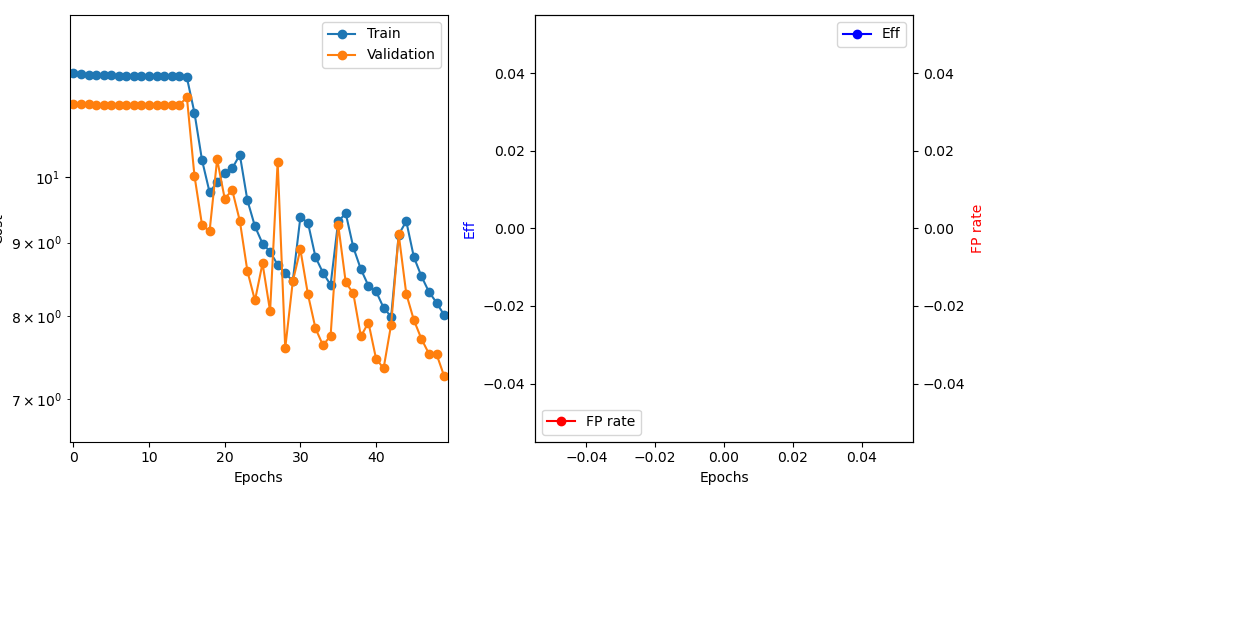

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

### Train the model

In [9]:
# save initial model state
param_states.append(get_param_state(model))
torch.save(model.state_dict(), output / f'{name}_init.pyt')

for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start = len(results),
                        notebook = True,
                        ep_optimizer = ep_optimizer,
                        lr_scheduler = lr_scheduler,
                        careful = careful,
                        adaptive = adaptive
                      ):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')
    #mine
    param_states.append(get_param_state(model))
    
# save final model and stats
torch.save(model.state_dict(), output / f'{name}_final.pyt')
results.to_hdf(f'{name}_stats.hdf5', 'results')

Number of batches: train = 5000, val = 1250


Number of batches: train = 5000, val = 1250


Epoch 0: train=11.8058, val=11.2456, took 342.09 s


CAREFUL:
     loss increase percentage: -0.180
ADAPTIVE:
     dot: 0.196
     lr factor: 1.004
     lr changed to 0.00010039228075742722
Epoch 1: train=11.7846, val=11.2404, took 782.81 s


CAREFUL:
     loss increase percentage: -0.080
ADAPTIVE:
     dot: 0.238
     lr factor: 1.005
     lr changed to 0.00010086965438744787
Epoch 2: train=11.7751, val=11.2315, took 762.57 s


CAREFUL:
     loss increase percentage: -0.044
ADAPTIVE:
     dot: 0.232
     lr factor: 1.005
     lr changed to 0.00010133792335862041
Epoch 3: train=11.7699, val=11.228, took 776.65 s


CAREFUL:
     loss increase percentage: -0.022
ADAPTIVE:
     dot: 0.178
     lr factor: 1.004
     lr changed to 0.0001016978264574307
Epoch 4: train=11.7673, val=11.2266, took 776.67 s


CAREFUL:
     loss increase percentage: -0.013
ADAPTIVE:
     dot: 0.143
     lr factor: 1.003
     lr changed to 0.00010198922492504106
Epoch 5: train=11.7658, val=11.2253, took 793.23 s


CAREFUL:
     loss increase percentage: -0.013
ADAPTIVE:
     dot: 0.123
     lr factor: 1.002
     lr changed to 0.00010223965854655207
Epoch 6: train=11.7643, val=11.2249, took 738.65 s


CAREFUL:
     loss increase percentage: -0.010
ADAPTIVE:
     dot: 0.113
     lr factor: 1.002
     lr changed to 0.00010247063383468779
Epoch 7: train=11.7631, val=11.224, took 734.51 s


CAREFUL:
     loss increase percentage: -0.009
ADAPTIVE:
     dot: 0.113
     lr factor: 1.002
     lr changed to 0.00010270145908208855
Epoch 8: train=11.7621, val=11.2239, took 740.45 s


CAREFUL:
     loss increase percentage: -0.010
ADAPTIVE:
     dot: 0.109
     lr factor: 1.002
     lr changed to 0.00010292567263493704
Epoch 9: train=11.7609, val=11.2233, took 800.91 s


CAREFUL:
     loss increase percentage: -0.007
ADAPTIVE:
     dot: 0.106
     lr factor: 1.002
     lr changed to 0.00010314344387054386
Epoch 10: train=11.76, val=11.2231, took 776.8 s


CAREFUL:
     loss increase percentage: -0.008
ADAPTIVE:
     dot: 0.111
     lr factor: 1.002
     lr changed to 0.0001033730840557596
Epoch 11: train=11.7591, val=11.2227, took 773.05 s


CAREFUL:
     loss increase percentage: -0.008
ADAPTIVE:
     dot: 0.113
     lr factor: 1.002
     lr changed to 0.00010360620946359264
Epoch 12: train=11.7582, val=11.2222, took 769.66 s


CAREFUL:
     loss increase percentage: -0.009
ADAPTIVE:
     dot: 0.115
     lr factor: 1.002
     lr changed to 0.00010384357115450393
Epoch 13: train=11.7571, val=11.2219, took 754.48 s


CAREFUL:
     loss increase percentage: -0.017
ADAPTIVE:
     dot: 0.123
     lr factor: 1.002
     lr changed to 0.00010409989347289214
Epoch 14: train=11.7551, val=11.2171, took 708.34 s


CAREFUL:
     loss increase percentage: -0.230
ADAPTIVE:
     dot: 0.133
     lr factor: 1.003
     lr changed to 0.00010437685053728777
Epoch 15: train=11.7281, val=11.3645, took 783.62 s


CAREFUL:
     loss increase percentage: -5.476
ADAPTIVE:
     dot: 0.064
     lr factor: 1.001
     lr changed to 0.0001045102527872028
Epoch 16: train=11.0858, val=10.0223, took 826.05 s


CAREFUL:
     loss increase percentage: -7.320
ADAPTIVE:
     dot: 0.124
     lr factor: 1.002
     lr changed to 0.0001047683992255171
Epoch 17: train=10.2744, val=9.26179, took 780.26 s


CAREFUL:
     loss increase percentage: -5.012
ADAPTIVE:
     dot: 0.272
     lr factor: 1.005
     lr changed to 0.00010533763881971398
Epoch 18: train=9.75947, val=9.16443, took 793.44 s


CAREFUL:
     loss increase percentage: 1.565
ADAPTIVE:
     dot: 0.195
     lr factor: 1.004
     lr changed to 0.0001057478901755896
Epoch 19: train=9.91225, val=10.2863, took 736.78 s


CAREFUL:
     loss increase percentage: 1.546
ADAPTIVE:
     dot: 0.069
     lr factor: 1.001
     lr changed to 0.00010589277976486941
Epoch 20: train=10.0655, val=9.6582, took 757.38 s


CAREFUL:
     loss increase percentage: 0.728
ADAPTIVE:
     dot: 0.094
     lr factor: 1.002
     lr changed to 0.00010609206467132602
Epoch 21: train=10.1387, val=9.78985, took 788.13 s


CAREFUL:
     loss increase percentage: 2.199
     loss increase too large
     lr changed to 8.487365173706082e-05
ADAPTIVE:
     dot: 0.092
     lr factor: 1.002
     lr changed to 8.50294586354501e-05
Epoch 22: train=10.3616, val=9.31884, took 857.03 s


CAREFUL:
     loss increase percentage: -7.037
ADAPTIVE:
     dot: 0.204
     lr factor: 1.004
     lr changed to 8.537632540188736e-05
Epoch 23: train=9.63246, val=8.59937, took 846.83 s


CAREFUL:
     loss increase percentage: -4.091
ADAPTIVE:
     dot: 0.381
     lr factor: 1.008
     lr changed to 8.602758520426316e-05
Epoch 24: train=9.23836, val=8.20352, took 835.45 s


CAREFUL:
     loss increase percentage: -2.717
ADAPTIVE:
     dot: 0.428
     lr factor: 1.009
     lr changed to 8.676346072928392e-05
Epoch 25: train=8.98737, val=8.70675, took 814.86 s


CAREFUL:
     loss increase percentage: -1.284
ADAPTIVE:
     dot: 0.401
     lr factor: 1.008
     lr changed to 8.745979899910833e-05
Epoch 26: train=8.87194, val=8.06415, took 773.41 s


CAREFUL:
     loss increase percentage: -2.095
ADAPTIVE:
     dot: 0.377
     lr factor: 1.008
     lr changed to 8.811847102880752e-05
Epoch 27: train=8.68606, val=10.2463, took 786.25 s


CAREFUL:
     loss increase percentage: -1.334
ADAPTIVE:
     dot: 0.336
     lr factor: 1.007
     lr changed to 8.871006242204965e-05
Epoch 28: train=8.57016, val=7.5984, took 834.67 s


Epoch 29: train=8.46394, val=8.45911, took 829.58 s


CAREFUL:
     loss increase percentage: 10.724
     loss increase too large
     lr changed to 7.14204605032676e-05
ADAPTIVE:
     dot: 0.057
     lr factor: 1.001
     lr changed to 7.150118276726346e-05
Epoch 30: train=9.37158, val=8.90292, took 821.94 s


CAREFUL:
     loss increase percentage: -0.833
ADAPTIVE:
     dot: 0.276
     lr factor: 1.006
     lr changed to 7.189613918621002e-05
Epoch 31: train=9.29347, val=8.28538, took 811.22 s


CAREFUL:
     loss increase percentage: -5.375
ADAPTIVE:
     dot: 0.466
     lr factor: 1.009
     lr changed to 7.256573440269993e-05
Epoch 32: train=8.79395, val=7.84506, took 836.14 s


CAREFUL:
     loss increase percentage: -2.492
ADAPTIVE:
     dot: 0.483
     lr factor: 1.010
     lr changed to 7.326662849505254e-05
Epoch 33: train=8.57482, val=7.63302, took 789.16 s


CAREFUL:
     loss increase percentage: -1.910
ADAPTIVE:
     dot: 0.452
     lr factor: 1.009
     lr changed to 7.39288121602056e-05
Epoch 34: train=8.41106, val=7.75541, took 849.84 s


CAREFUL:
     loss increase percentage: 10.715
     loss increase too large
     lr changed to 5.9143049728164484e-05
ADAPTIVE:
     dot: 0.128
     lr factor: 1.003
     lr changed to 5.9294625134656556e-05
Epoch 35: train=9.31231, val=9.26476, took 789.31 s


Epoch 36: train=9.43284, val=8.44427, took 819.13 s


CAREFUL:
     loss increase percentage: -5.309
ADAPTIVE:
     dot: 0.487
     lr factor: 1.010
     lr changed to 6.018229092473712e-05
Epoch 37: train=8.93206, val=8.29667, took 797.51 s


CAREFUL:
     loss increase percentage: -3.450
ADAPTIVE:
     dot: 0.522
     lr factor: 1.010
     lr changed to 6.0810865176132595e-05
Epoch 38: train=8.62395, val=7.7446, took 813.12 s


CAREFUL:
     loss increase percentage: -2.608
ADAPTIVE:
     dot: 0.508
     lr factor: 1.010
     lr changed to 6.142868307074729e-05
Epoch 39: train=8.39903, val=7.91843, took 818.07 s


CAREFUL:
     loss increase percentage: -0.868
ADAPTIVE:
     dot: 0.472
     lr factor: 1.009
     lr changed to 6.200827436465905e-05
Epoch 40: train=8.32615, val=7.47388, took 833.55 s


CAREFUL:
     loss increase percentage: -2.617
ADAPTIVE:
     dot: 0.447
     lr factor: 1.009
     lr changed to 6.256316839040335e-05
Epoch 41: train=8.10828, val=7.35723, took 821.84 s


CAREFUL:
     loss increase percentage: -1.434
ADAPTIVE:
     dot: 0.427
     lr factor: 1.009
     lr changed to 6.309728327407e-05
Epoch 42: train=7.99203, val=7.8929, took 821.17 s


CAREFUL:
     loss increase percentage: 14.083
     loss increase too large
     lr changed to 5.0477826619256e-05
ADAPTIVE:
     dot: 0.096
     lr factor: 1.002
     lr changed to 5.057522358339513e-05
Epoch 43: train=9.11755, val=9.11939, took 802.32 s


CAREFUL:
     loss increase percentage: 2.154
     loss increase too large
     lr changed to 4.0460178866716105e-05
ADAPTIVE:
     dot: 0.305
     lr factor: 1.006
     lr changed to 4.070673655441017e-05
Epoch 44: train=9.31394, val=8.29138, took 820.38 s


CAREFUL:
     loss increase percentage: -5.574
ADAPTIVE:
     dot: 0.531
     lr factor: 1.011
     lr changed to 4.1138970244050824e-05
Epoch 45: train=8.79477, val=7.95015, took 830.25 s


CAREFUL:
     loss increase percentage: -3.022
ADAPTIVE:
     dot: 0.590
     lr factor: 1.012
     lr changed to 4.162441477933389e-05
Epoch 46: train=8.529, val=7.71431, took 816.87 s


CAREFUL:
     loss increase percentage: -2.498
ADAPTIVE:
     dot: 0.538
     lr factor: 1.011
     lr changed to 4.207264393929316e-05
Epoch 47: train=8.31593, val=7.53127, took 812.82 s


CAREFUL:
     loss increase percentage: -1.682
ADAPTIVE:
     dot: 0.538
     lr factor: 1.011
     lr changed to 4.252522244835047e-05
Epoch 48: train=8.17603, val=7.52675, took 800.94 s


CAREFUL:
     loss increase percentage: -1.982
ADAPTIVE:
     dot: 0.526
     lr factor: 1.011
     lr changed to 4.297263642353454e-05
Epoch 49: train=8.01394, val=7.26832, took 833.41 s



Save the plot above:

In [10]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

<IPython.core.display.Javascript object>

### Plotting the angle grid, step sizes, and the model outputs over training

In [12]:
# getting angles between steps
def angle_between(a, b):
    return np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

angle_grids = []
grid_size = 30
num_epochs = n_epochs

ep_intervals = [(np.arange(0, num_epochs+1, grid_size)[i], np.arange(0, num_epochs+1, grid_size)[i+1]) for i in range(len(np.arange(0, num_epochs+1, grid_size))-1)]

for interval in ep_intervals:
    
    these_param_states = []
    for i in range(interval[0], interval[1]):
        these_param_states.append(param_states[i])
        #print("Loaded", file_names[i])
        
    interval_size = len(these_param_states)-1    
    these_steps = [these_param_states[i+1]-these_param_states[i] for i in range(interval_size)]
    
    this_angle_grid = np.zeros((interval_size, interval_size))
    
    for i in range(interval_size):
        for j in range(i+1, interval_size):#range(i+1, interval_size):
            angle = angle_between(these_steps[i], these_steps[j])
            this_angle_grid[i,j] = angle
            this_angle_grid[j,i] = angle
            
    angle_grids.append(this_angle_grid)
    
    
# getting sizes of steps
step_sizes = []
for i in range(num_epochs-1):
    step_sizes.append(np.linalg.norm(param_states[i+1]-param_states[i]))

<IPython.core.display.Javascript object>


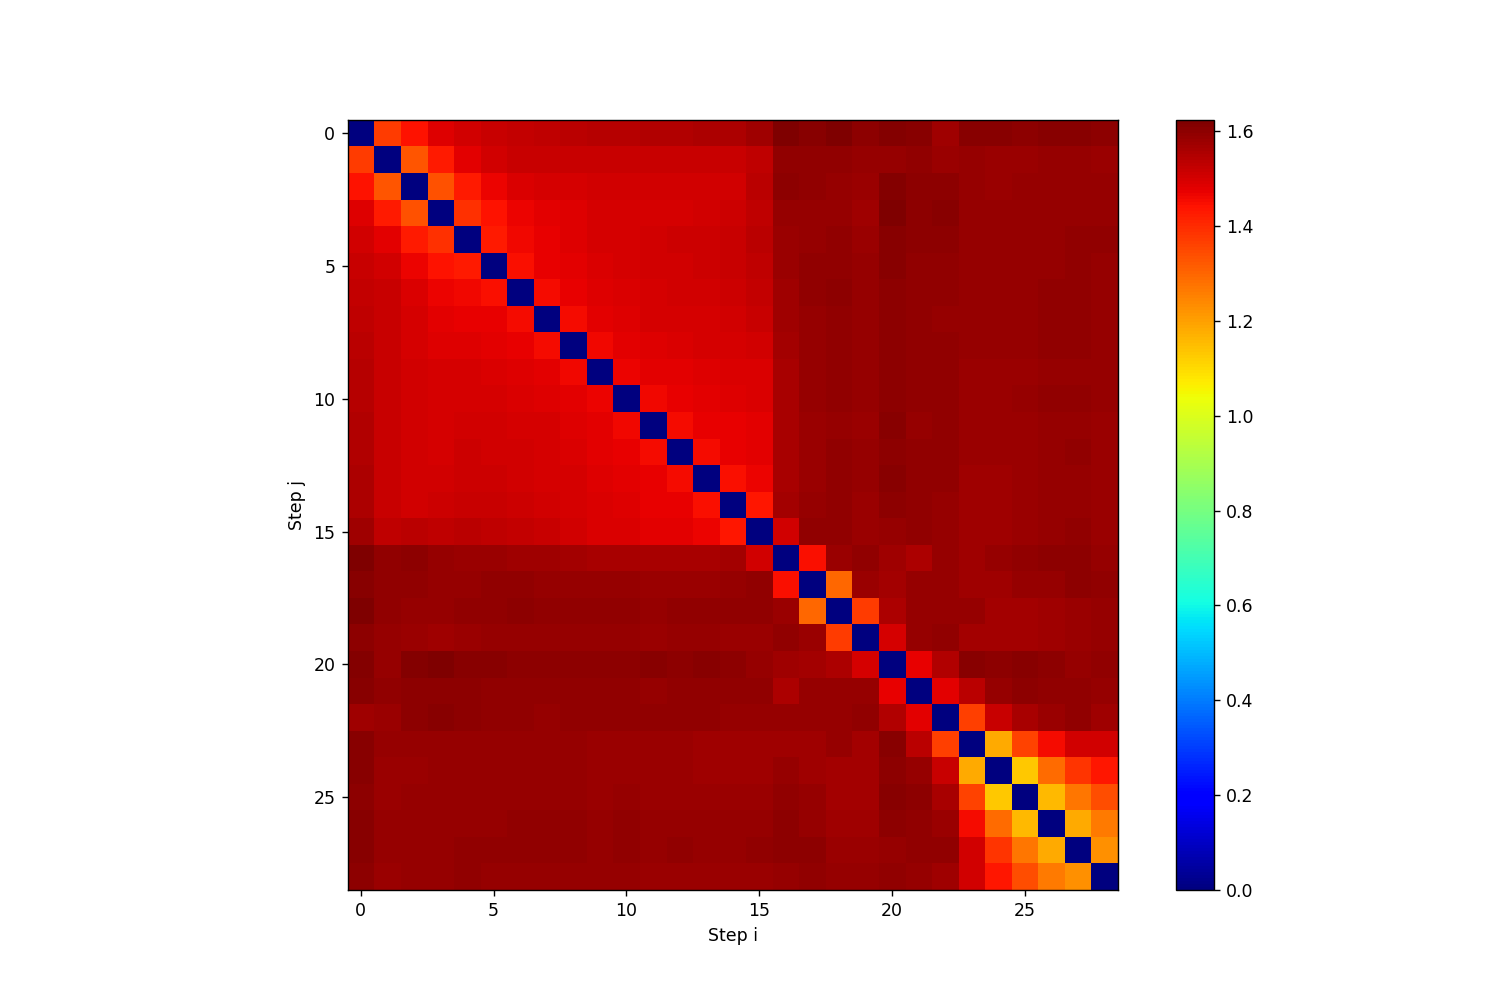

<IPython.core.display.Javascript object>


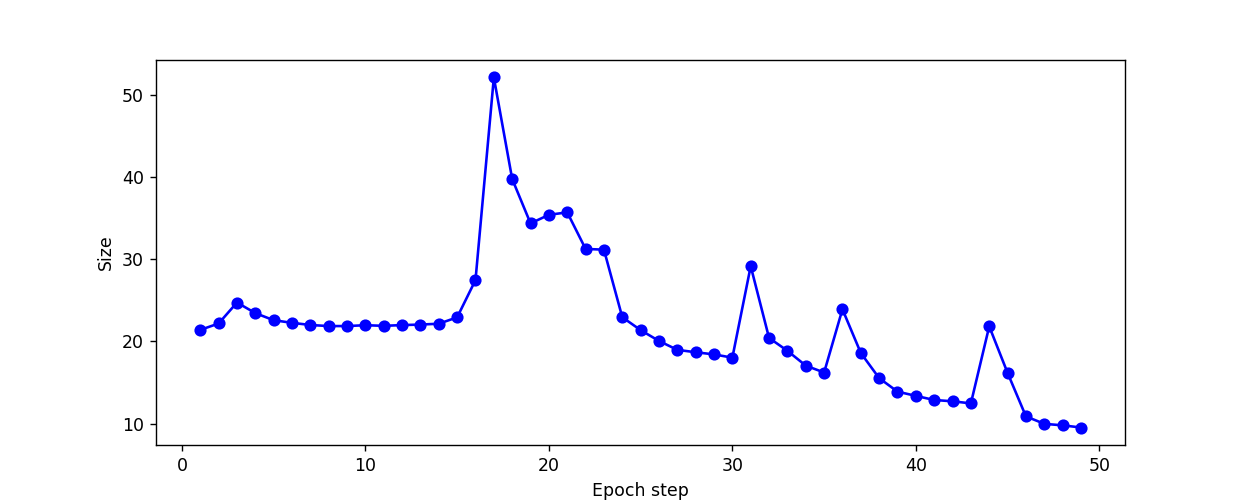

Text(0, 0.5, 'Size')

In [13]:
import matplotlib.colors as colors
import matplotlib.cm as cm

for angle_grid in angle_grids:
    plt.figure(figsize=(12,8))
    norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   
    plt.imshow(angle_grid, cmap=cm.jet)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
    plt.xlabel('Step i')
    plt.ylabel('Step j')
    
plt.figure()
plt.plot(np.arange(1, num_epochs), step_sizes, 'bo-')
plt.xlabel('Epoch step')
plt.ylabel('Size')

In [14]:
state_dicts = []
for i in np.arange(0, num_epochs, 1):
    state_dicts.append( (i, vector_to_state_dict(param_states[i], model)) )

data = load_data()

Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
labels shape: torch.Size([16, 12000])
nEvts: 16 | nFeatures: 4000
y shape: torch.Size([16, 3, 4000])
y shape: torch.Size([16, 4000, 3])


<IPython.core.display.Javascript object>


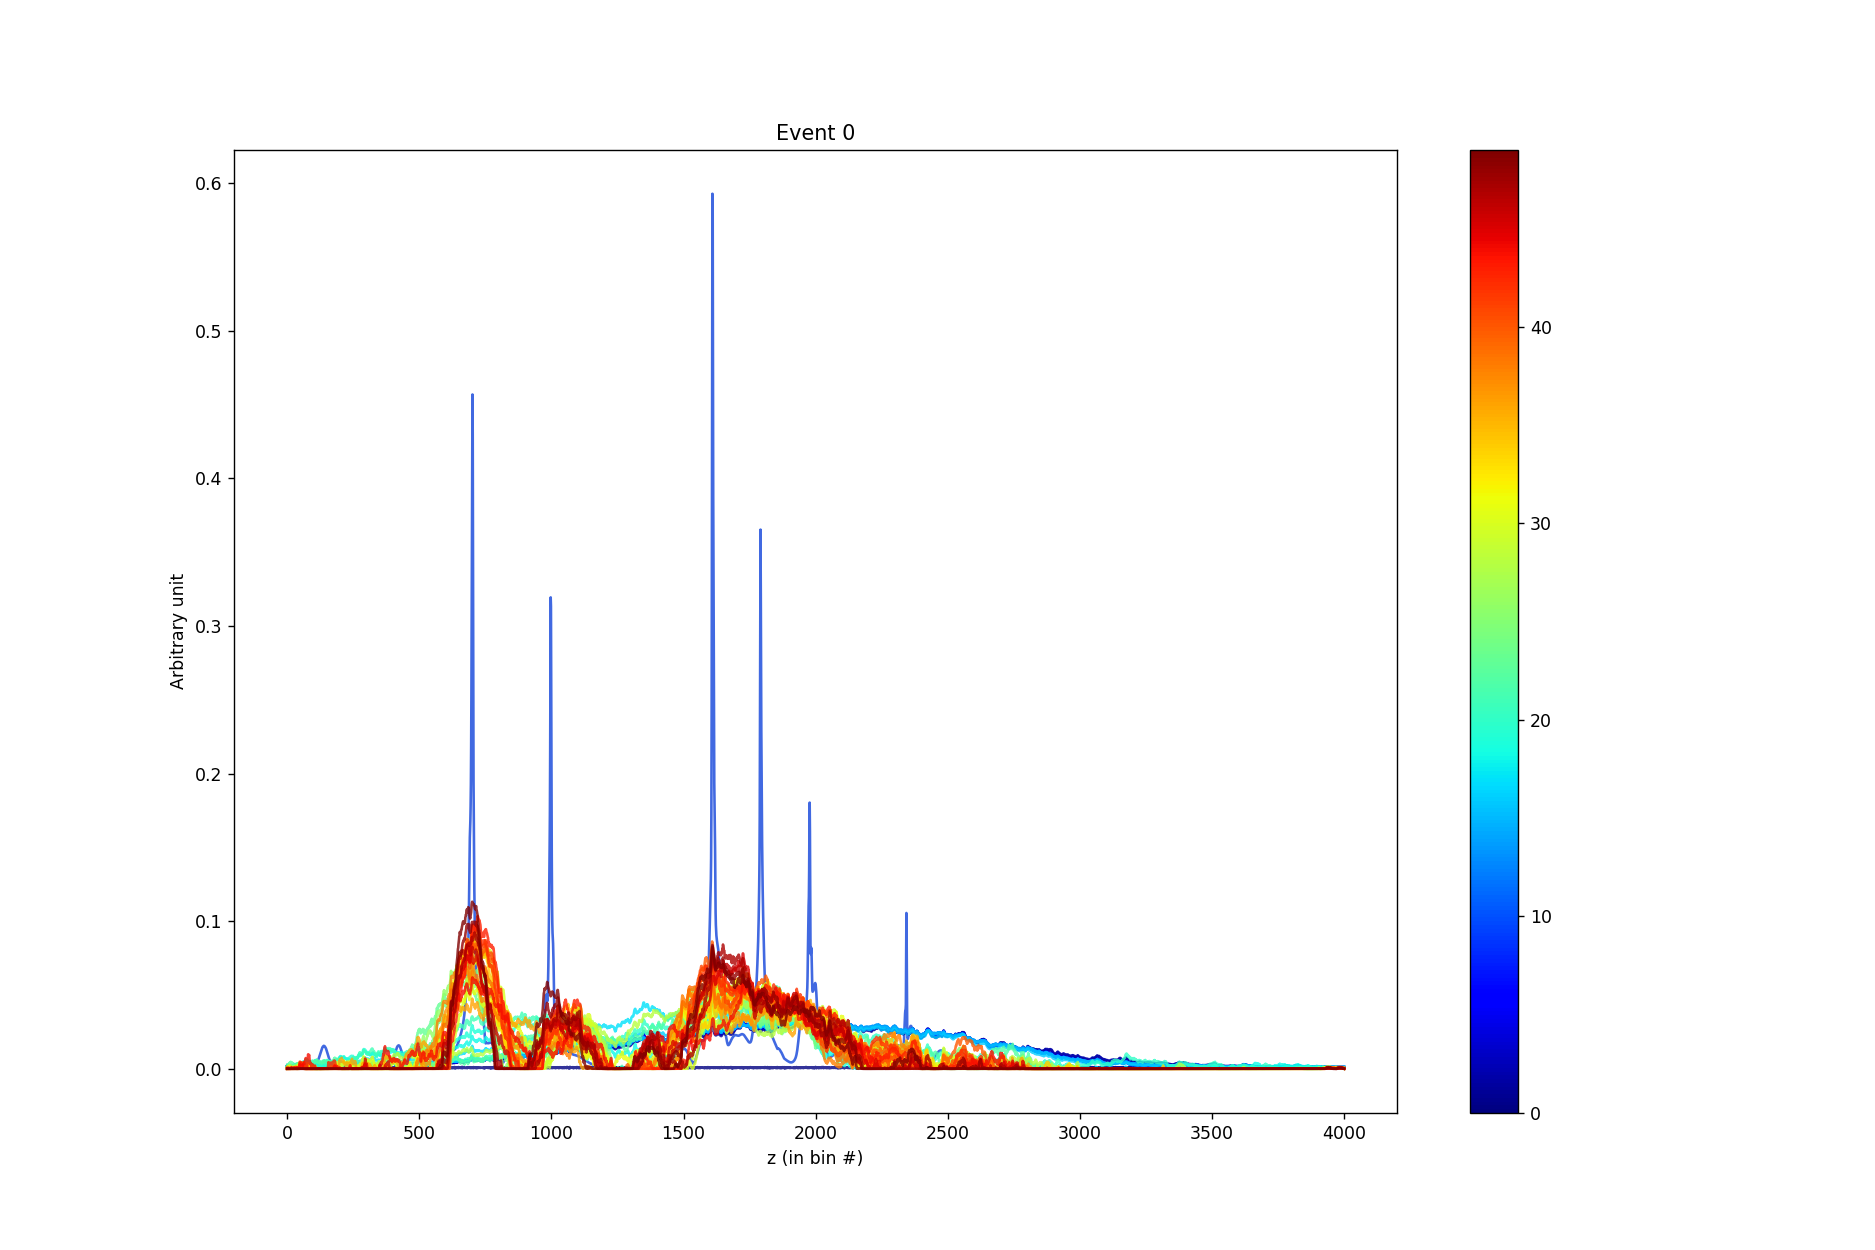

<IPython.core.display.Javascript object>


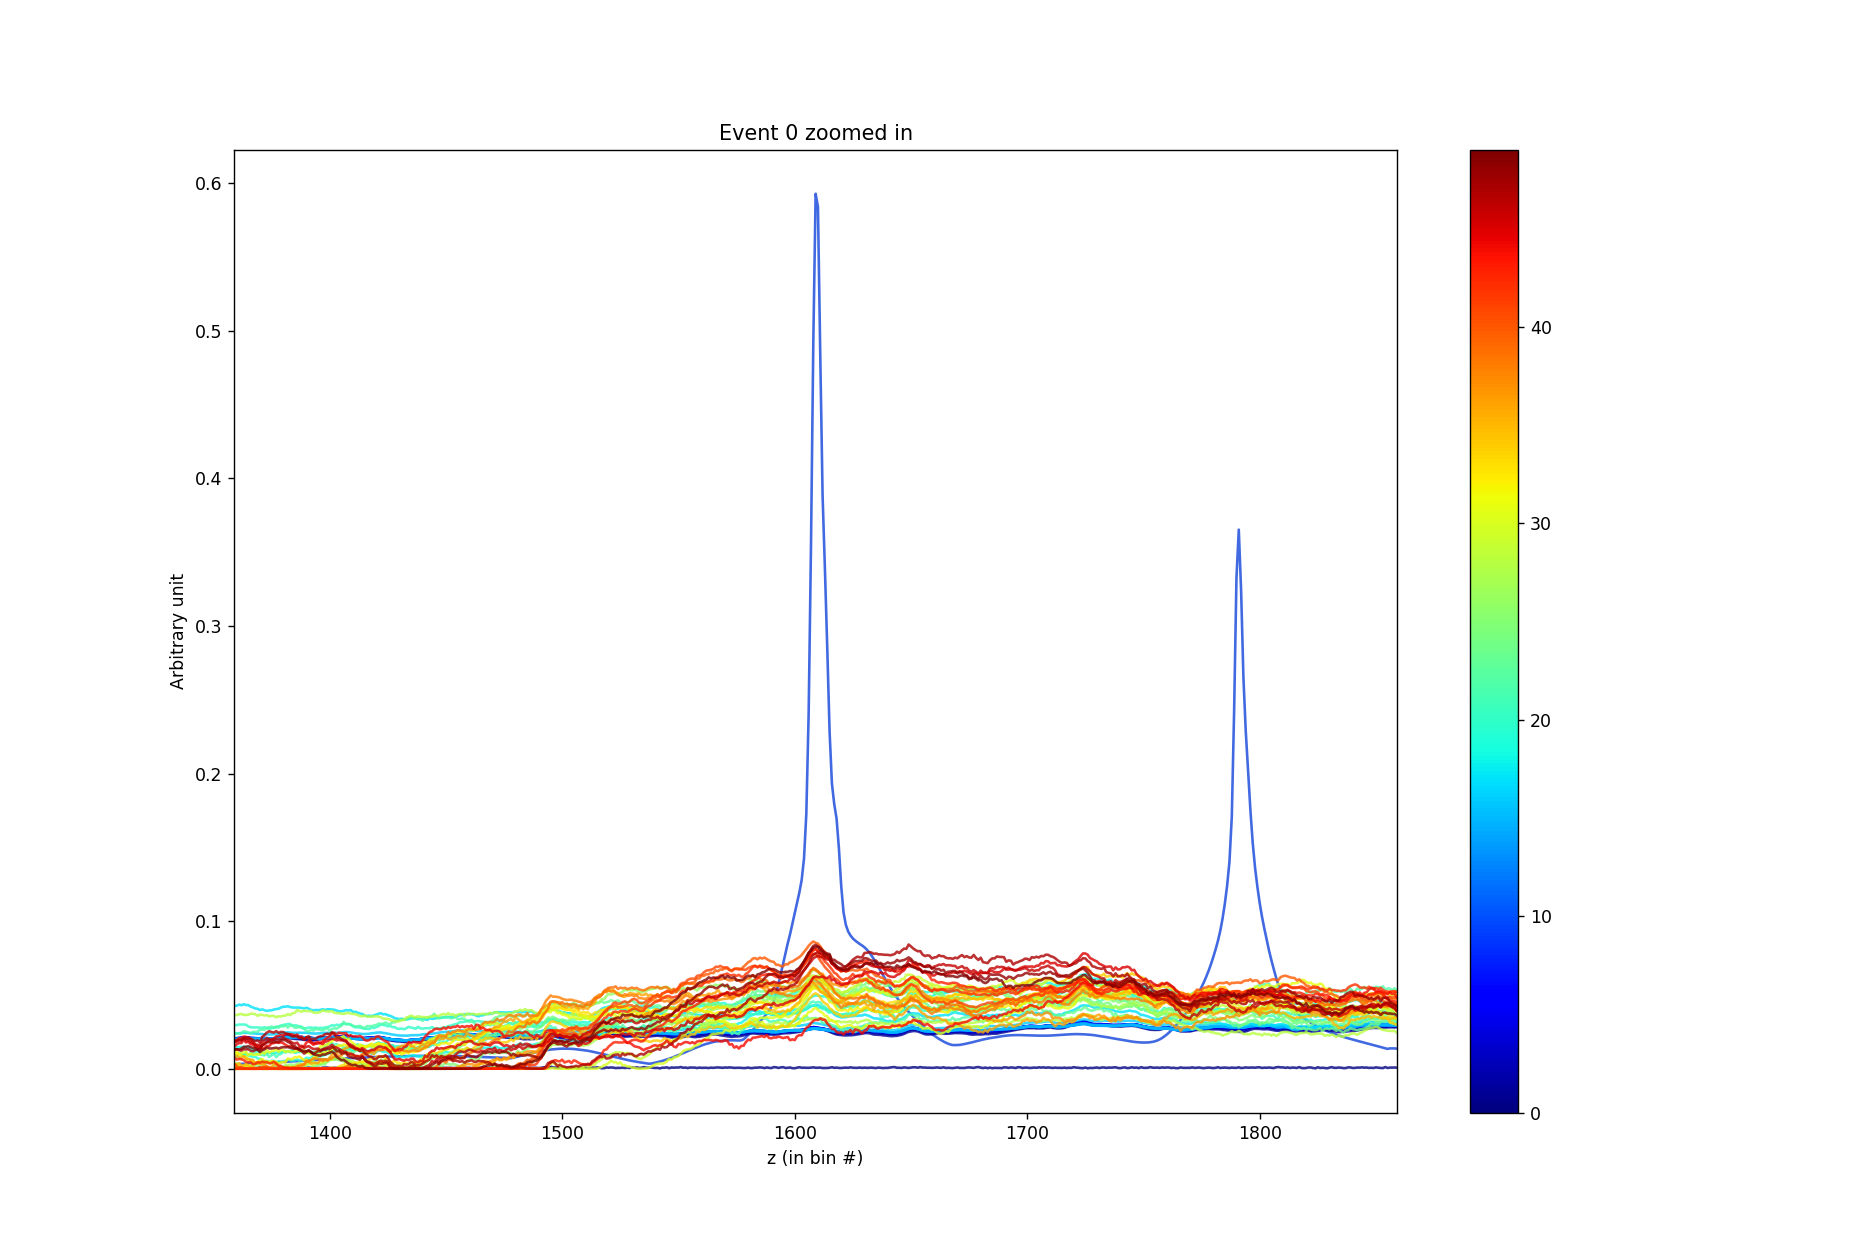

<IPython.core.display.Javascript object>


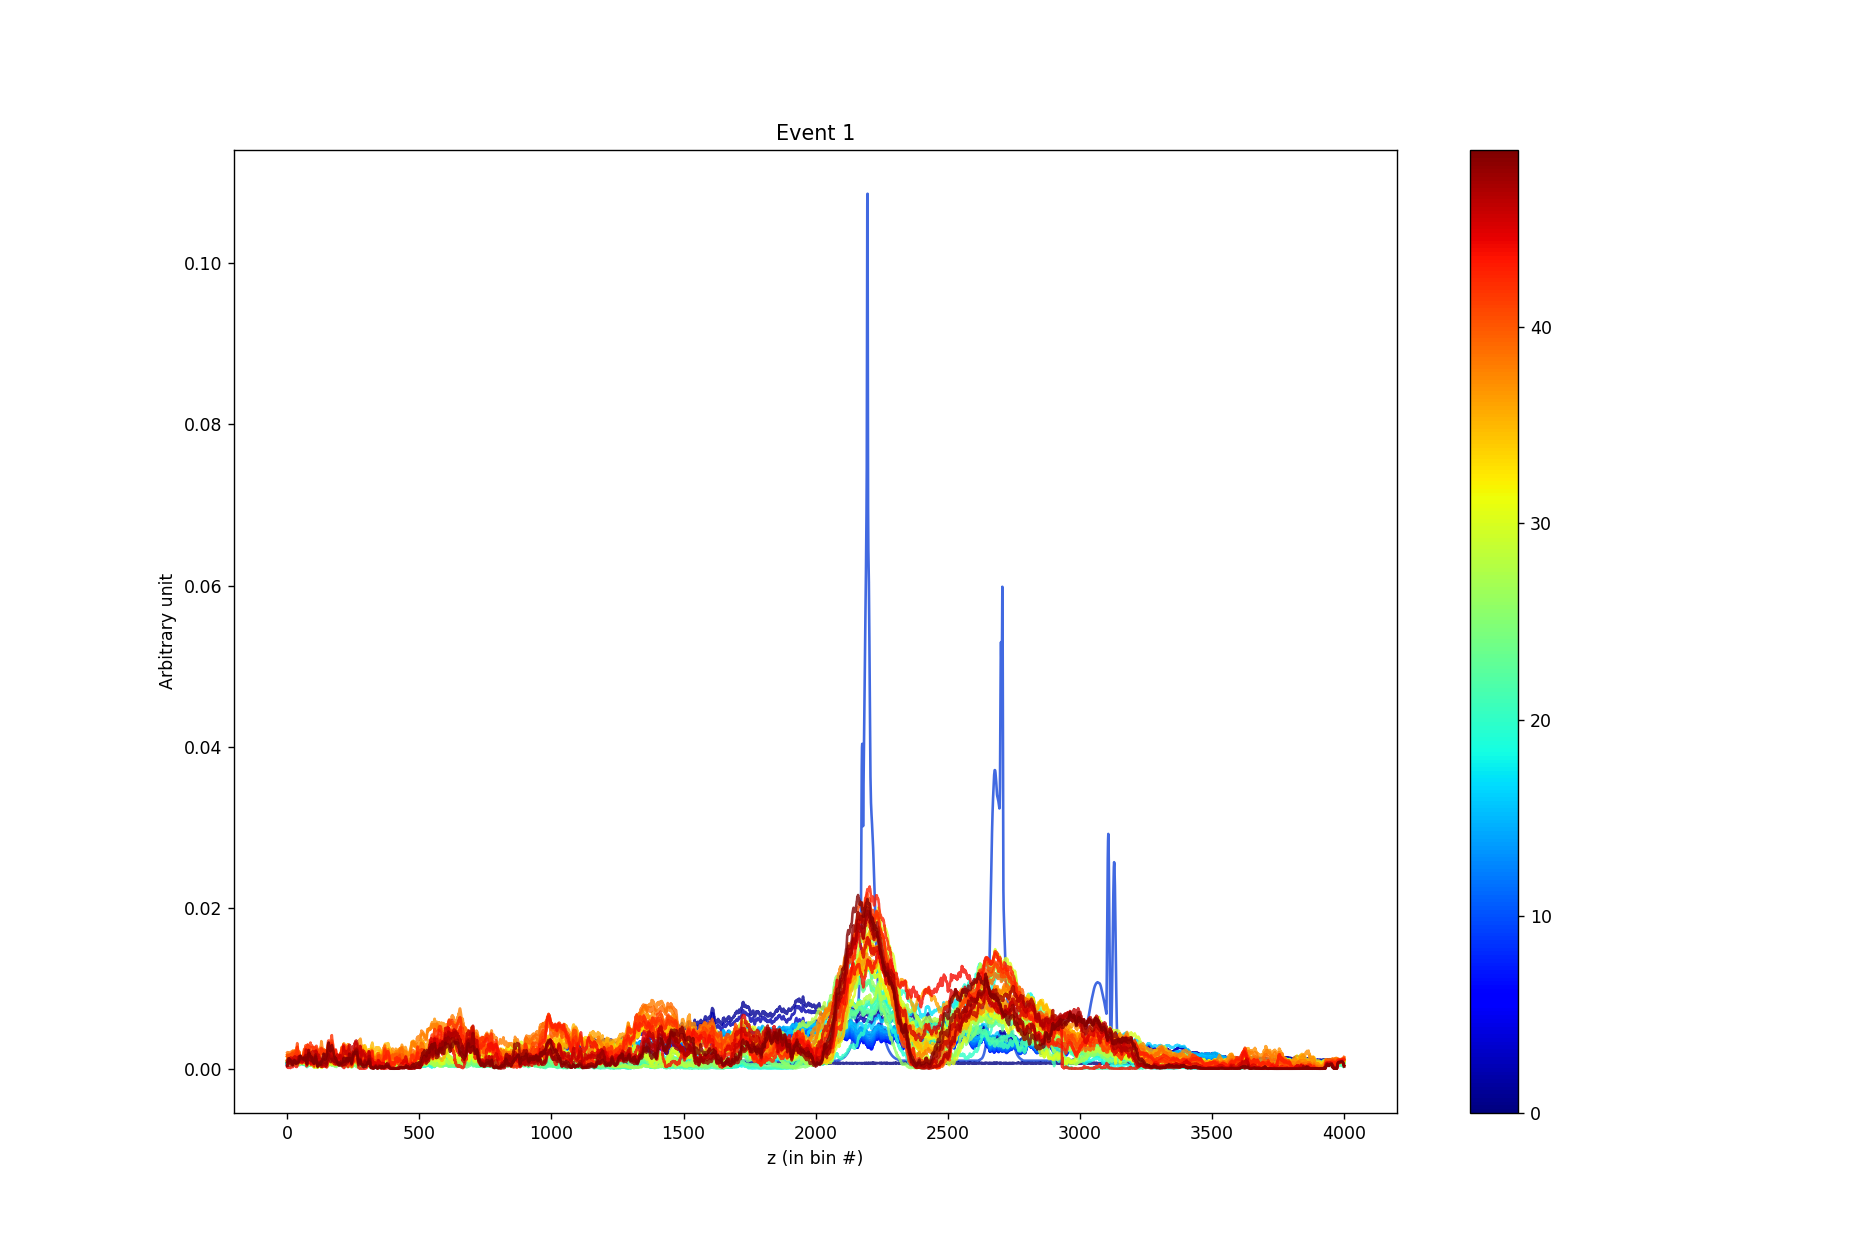

<IPython.core.display.Javascript object>


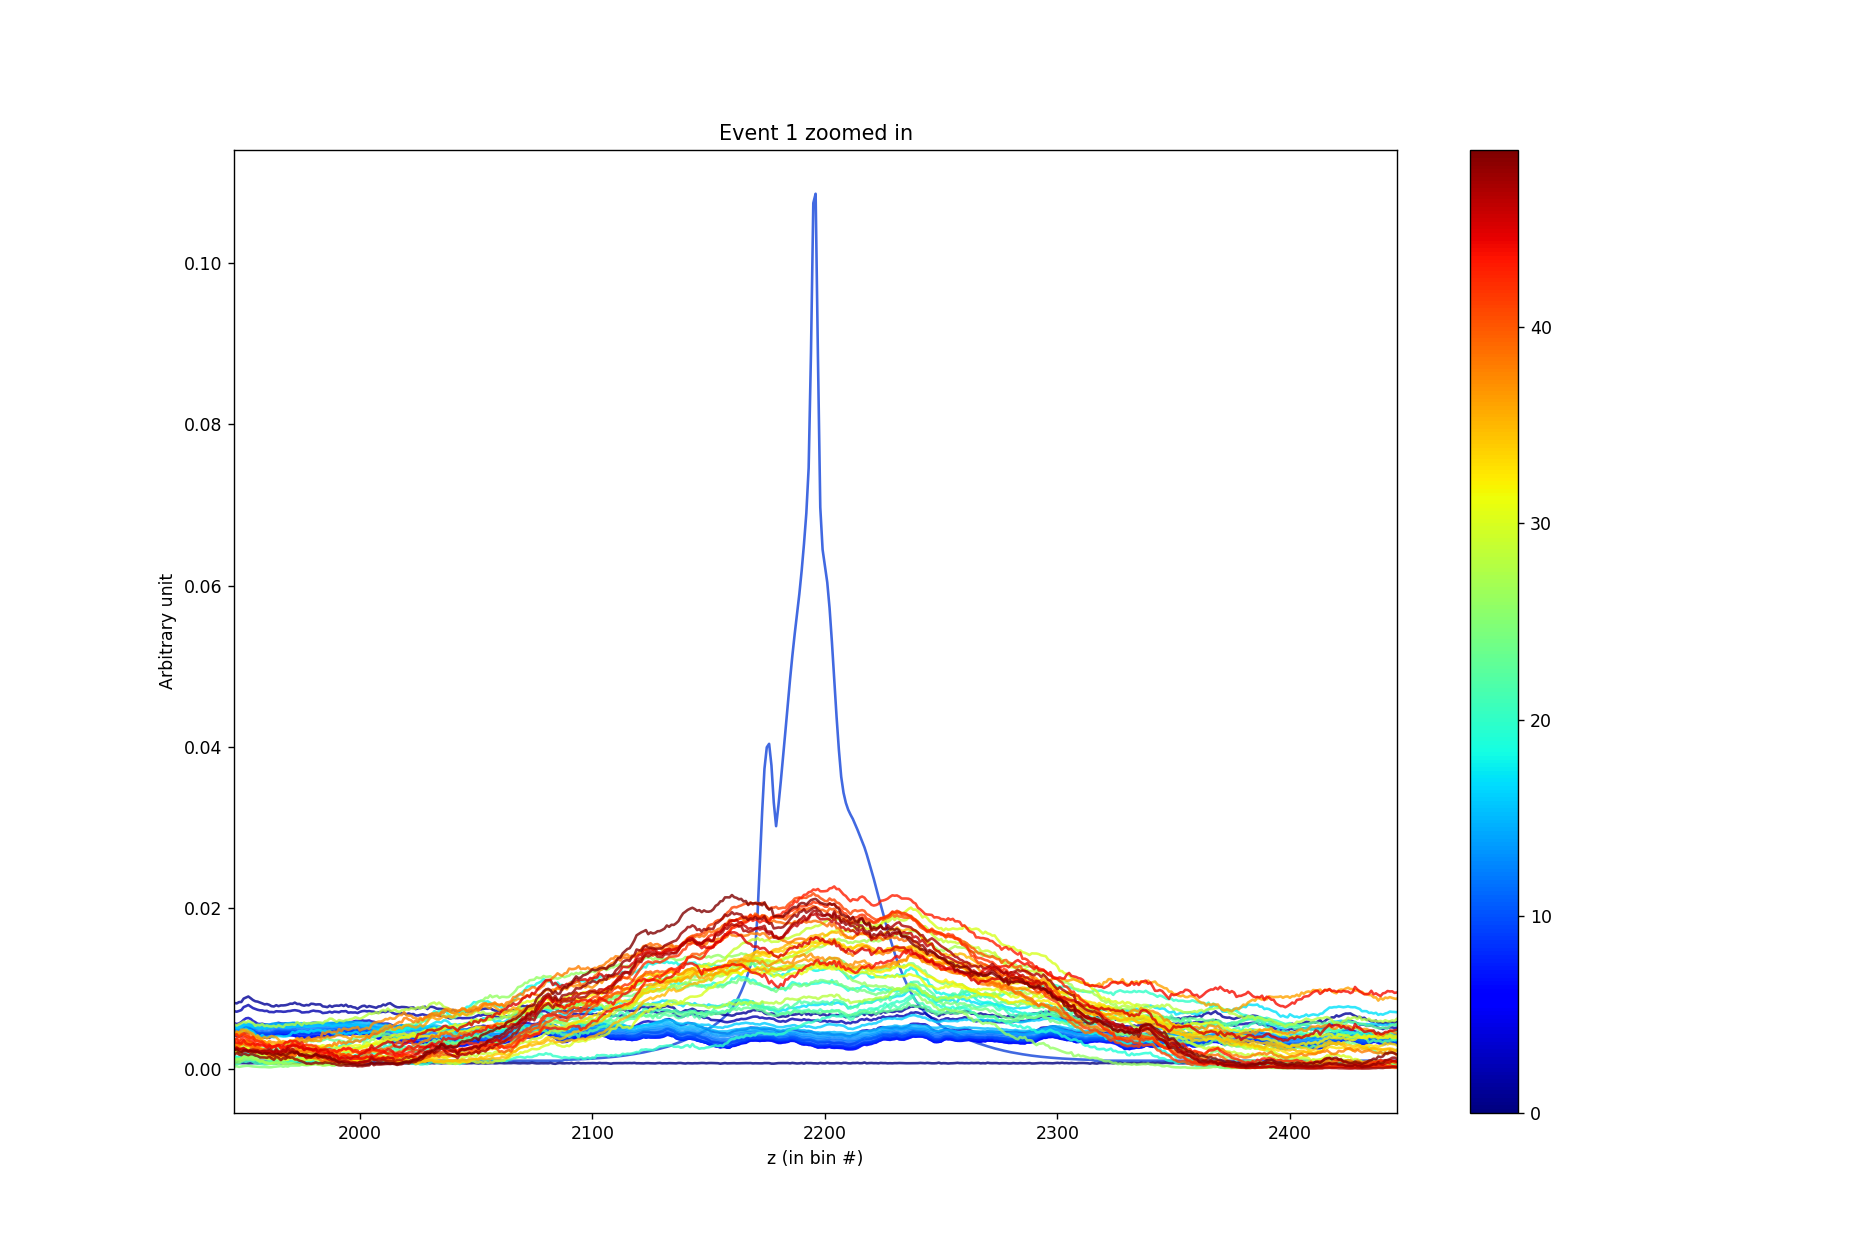

<IPython.core.display.Javascript object>


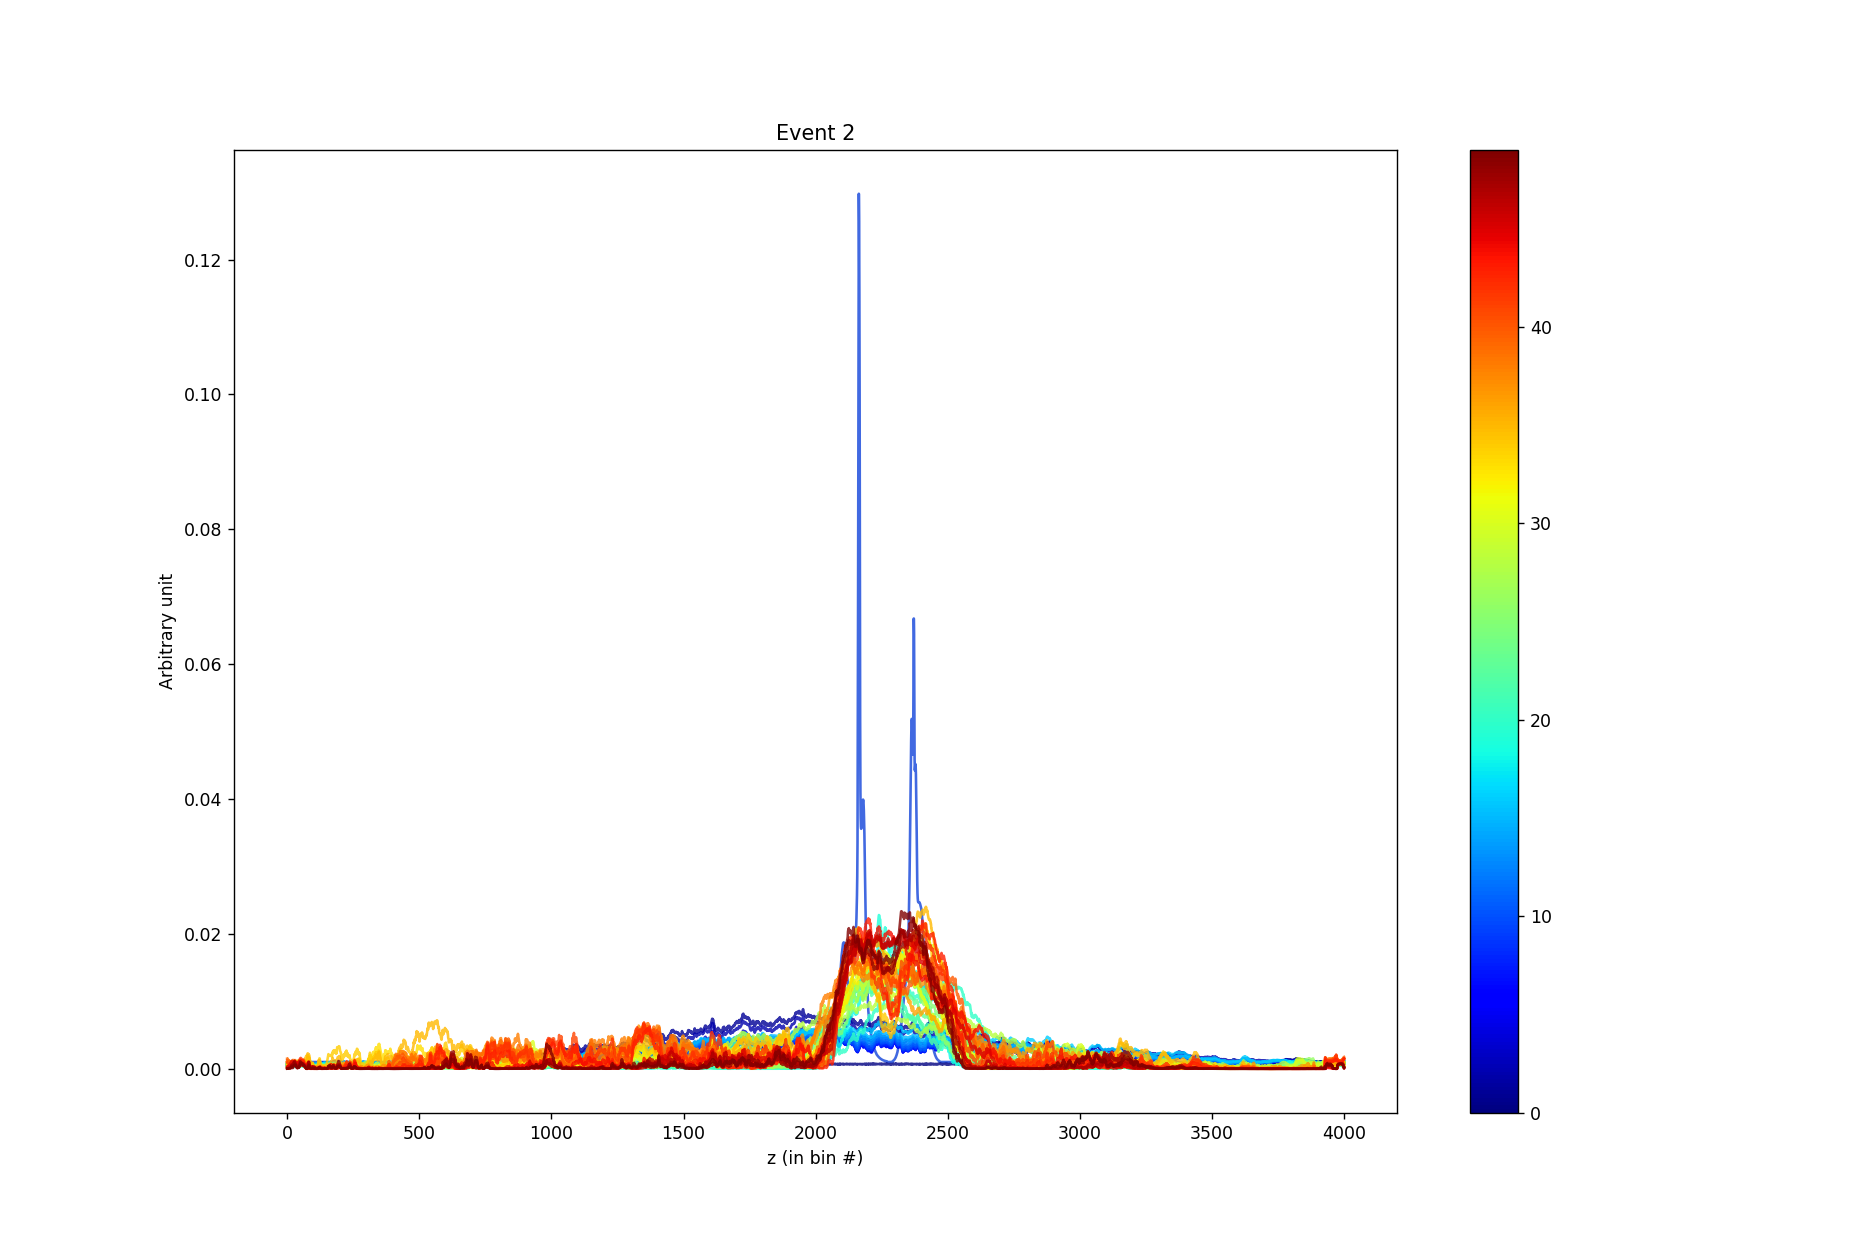

<IPython.core.display.Javascript object>


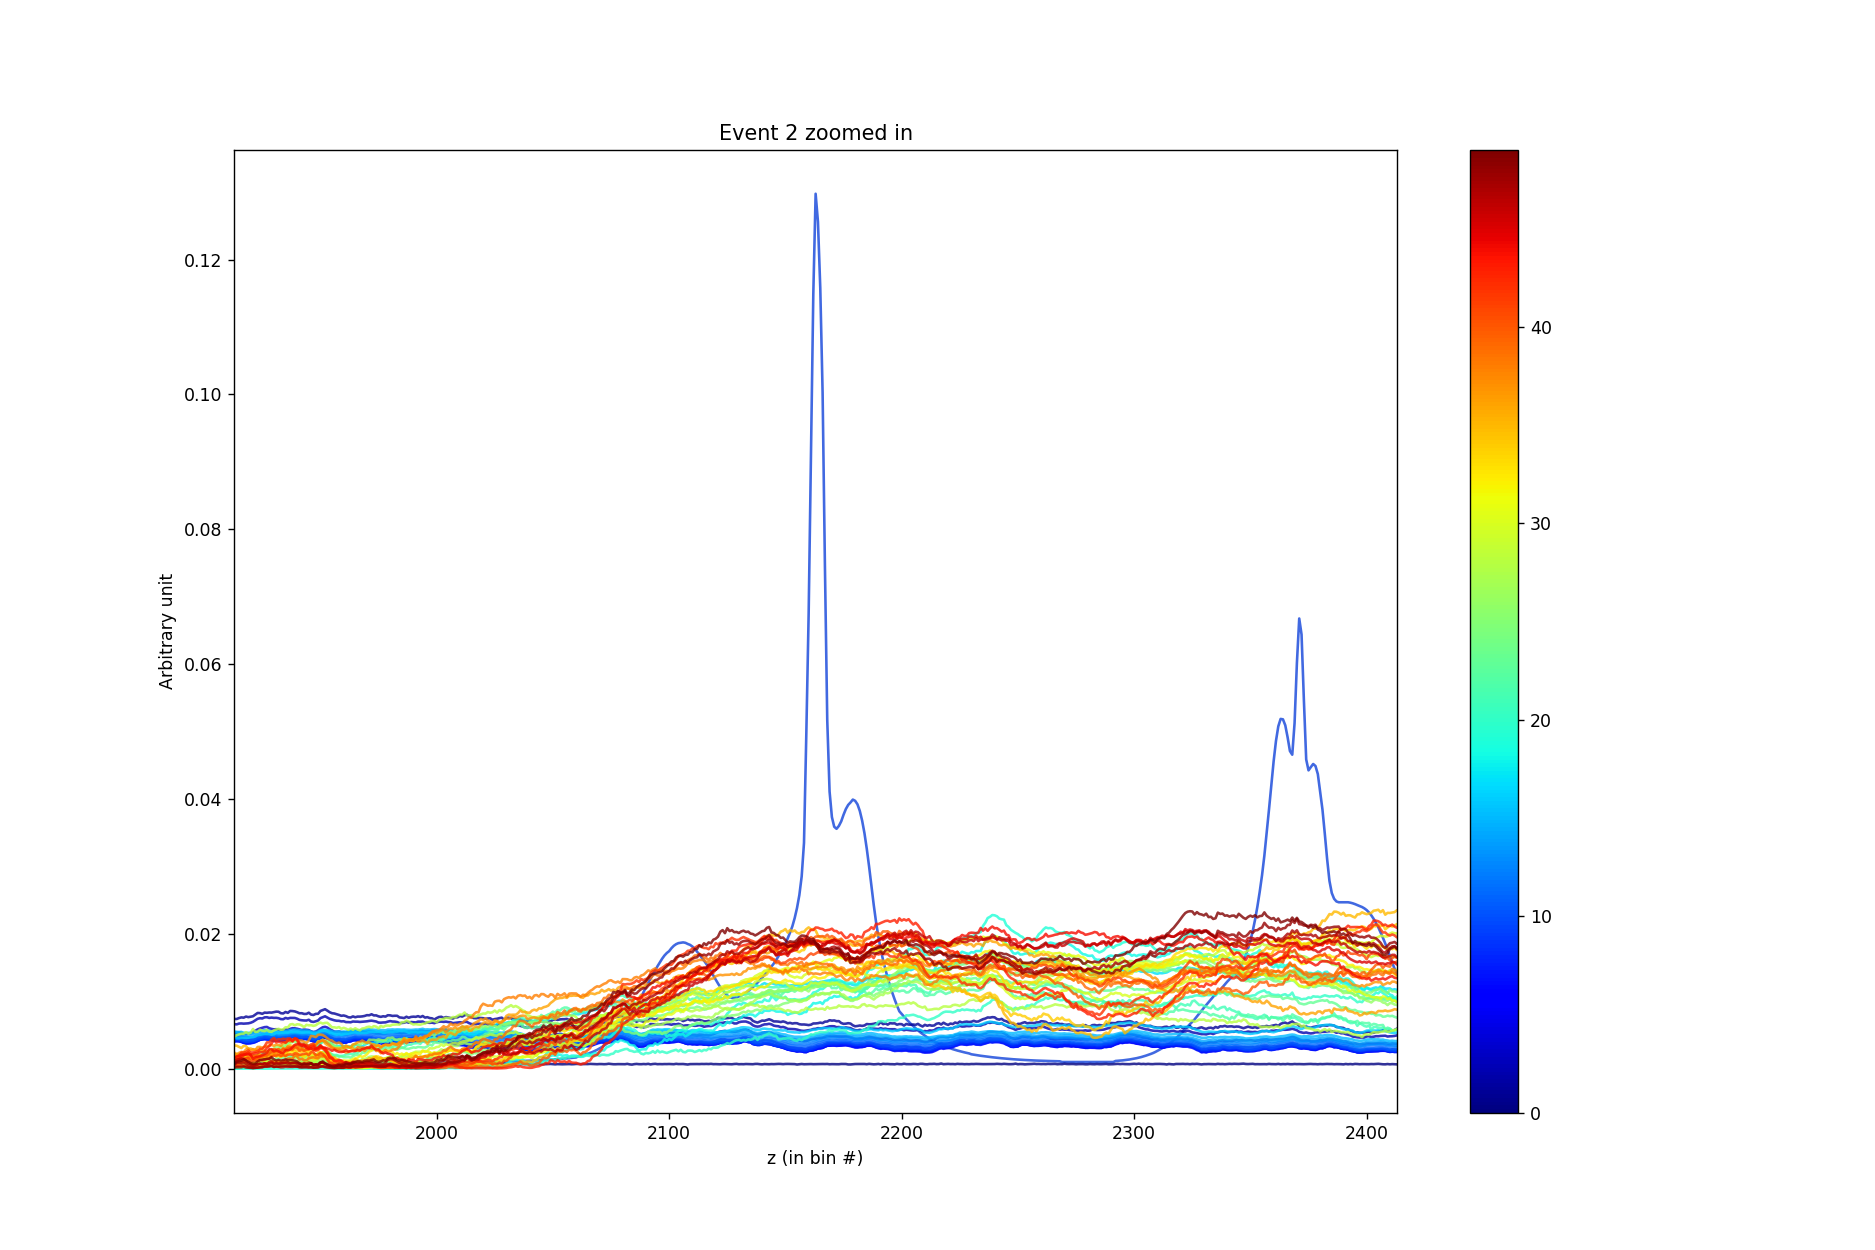

<IPython.core.display.Javascript object>


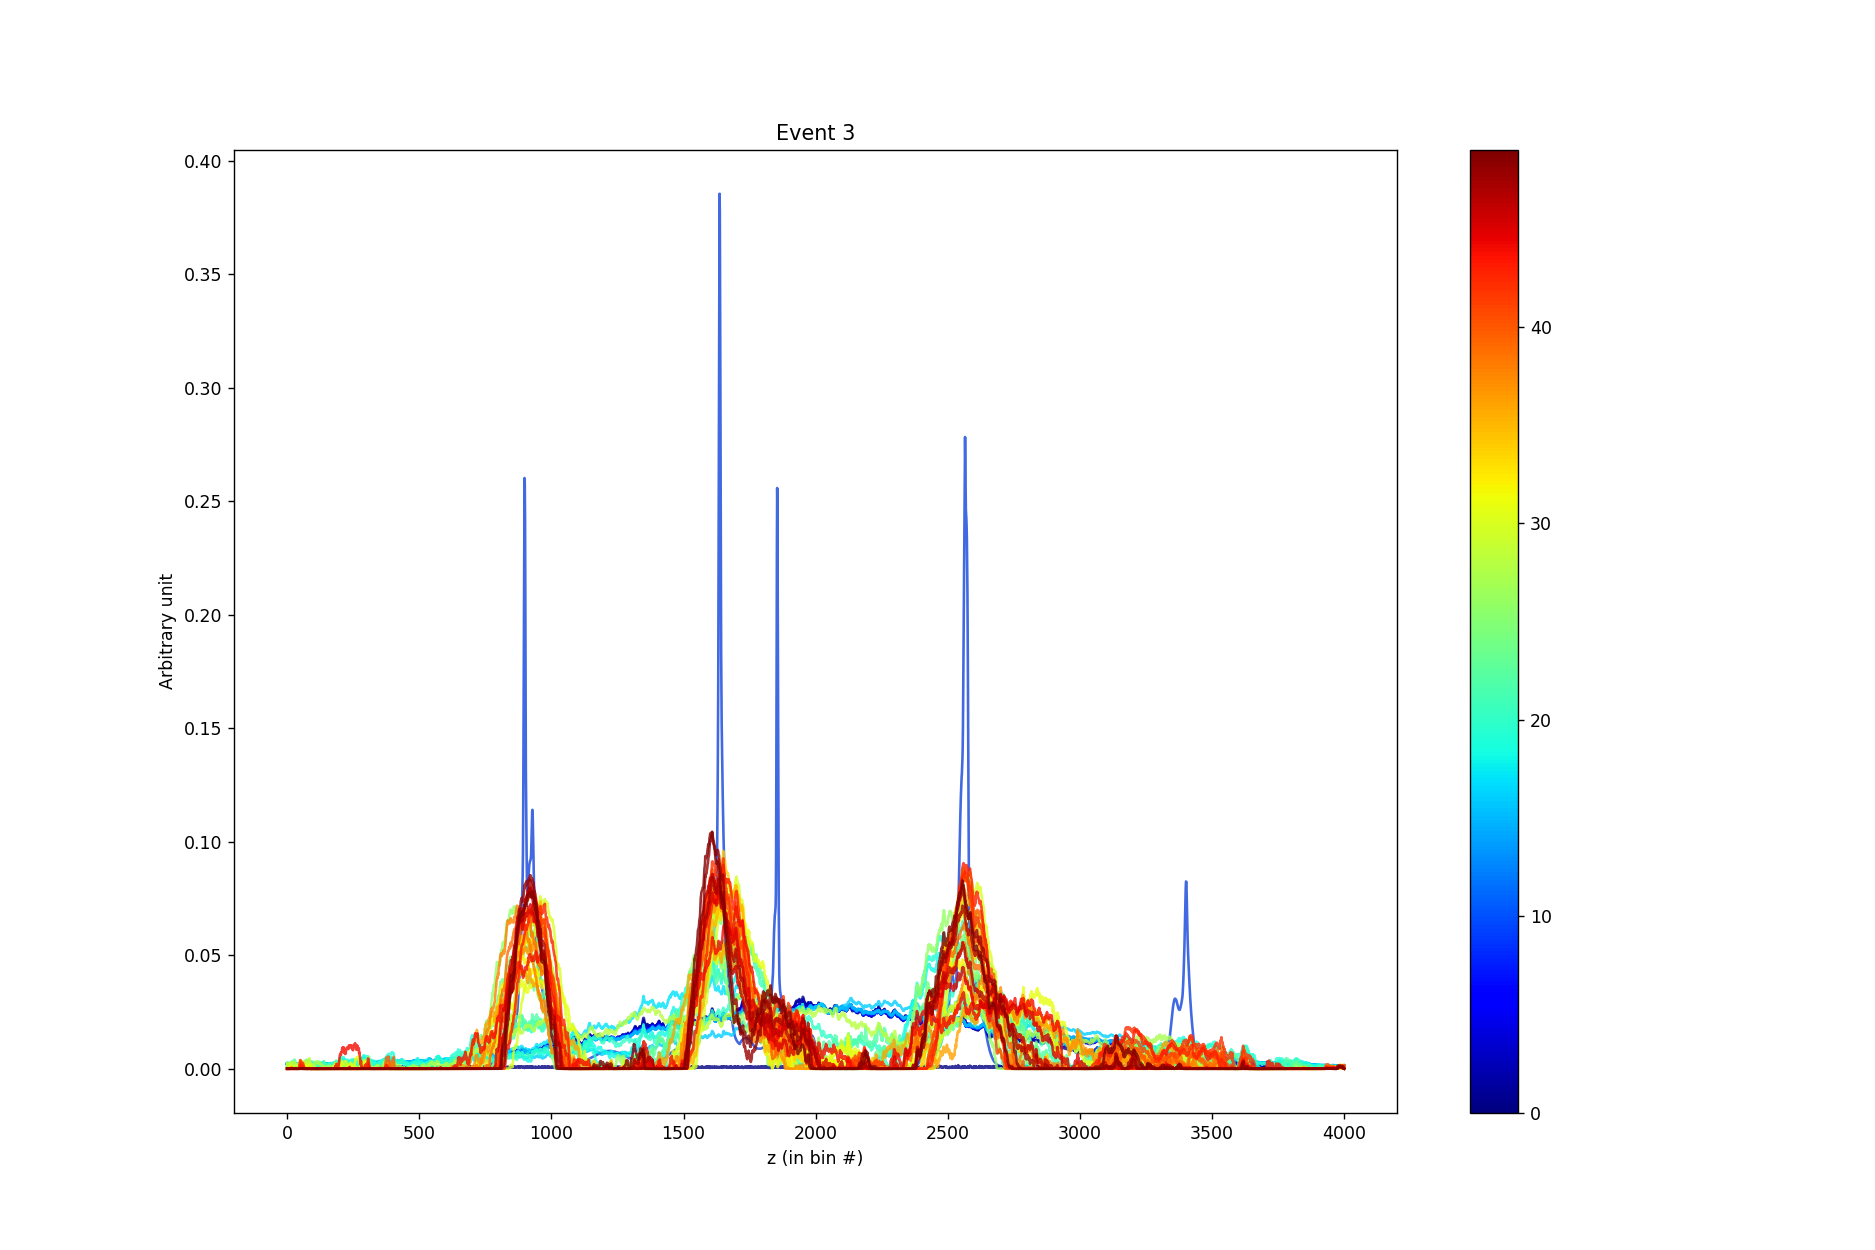

<IPython.core.display.Javascript object>


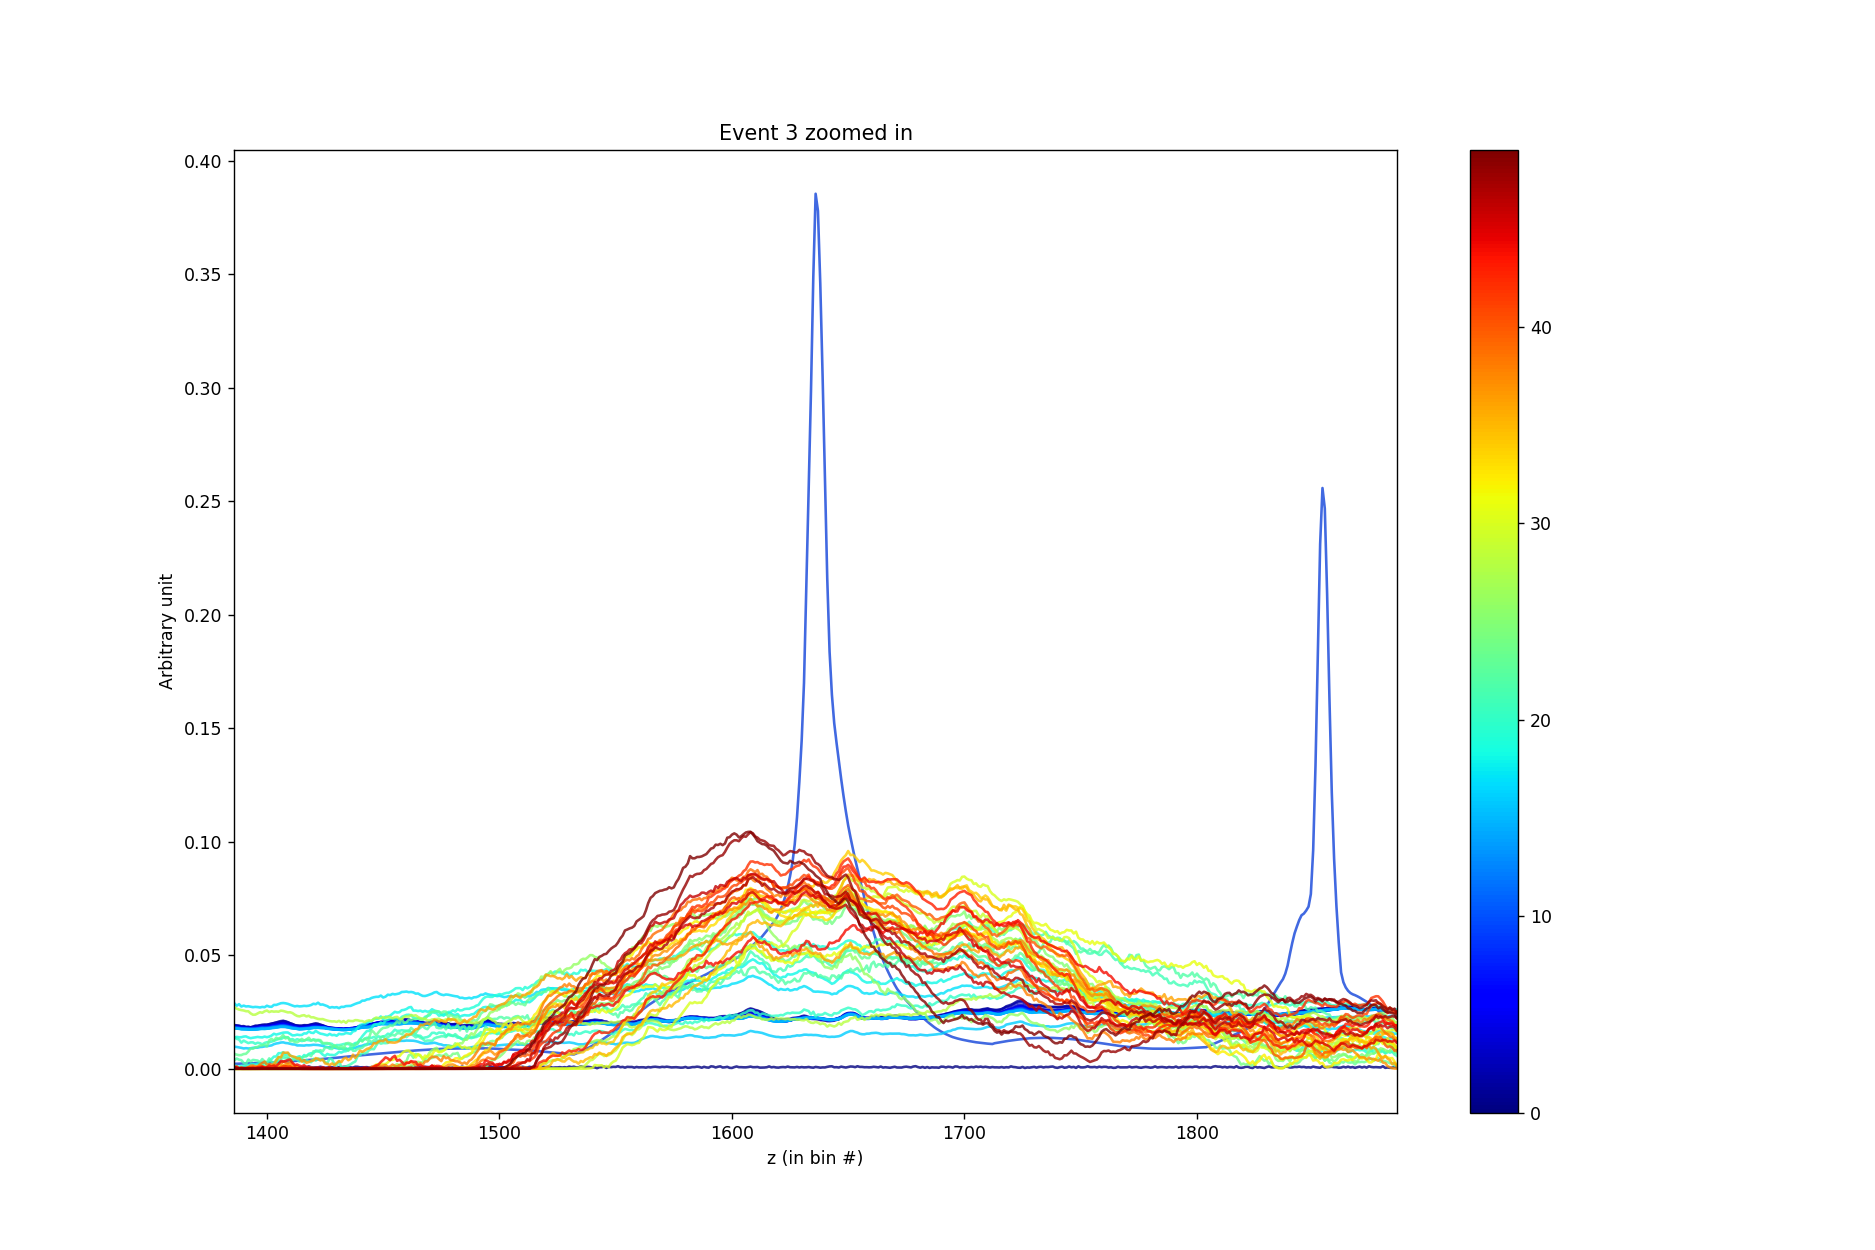

<IPython.core.display.Javascript object>


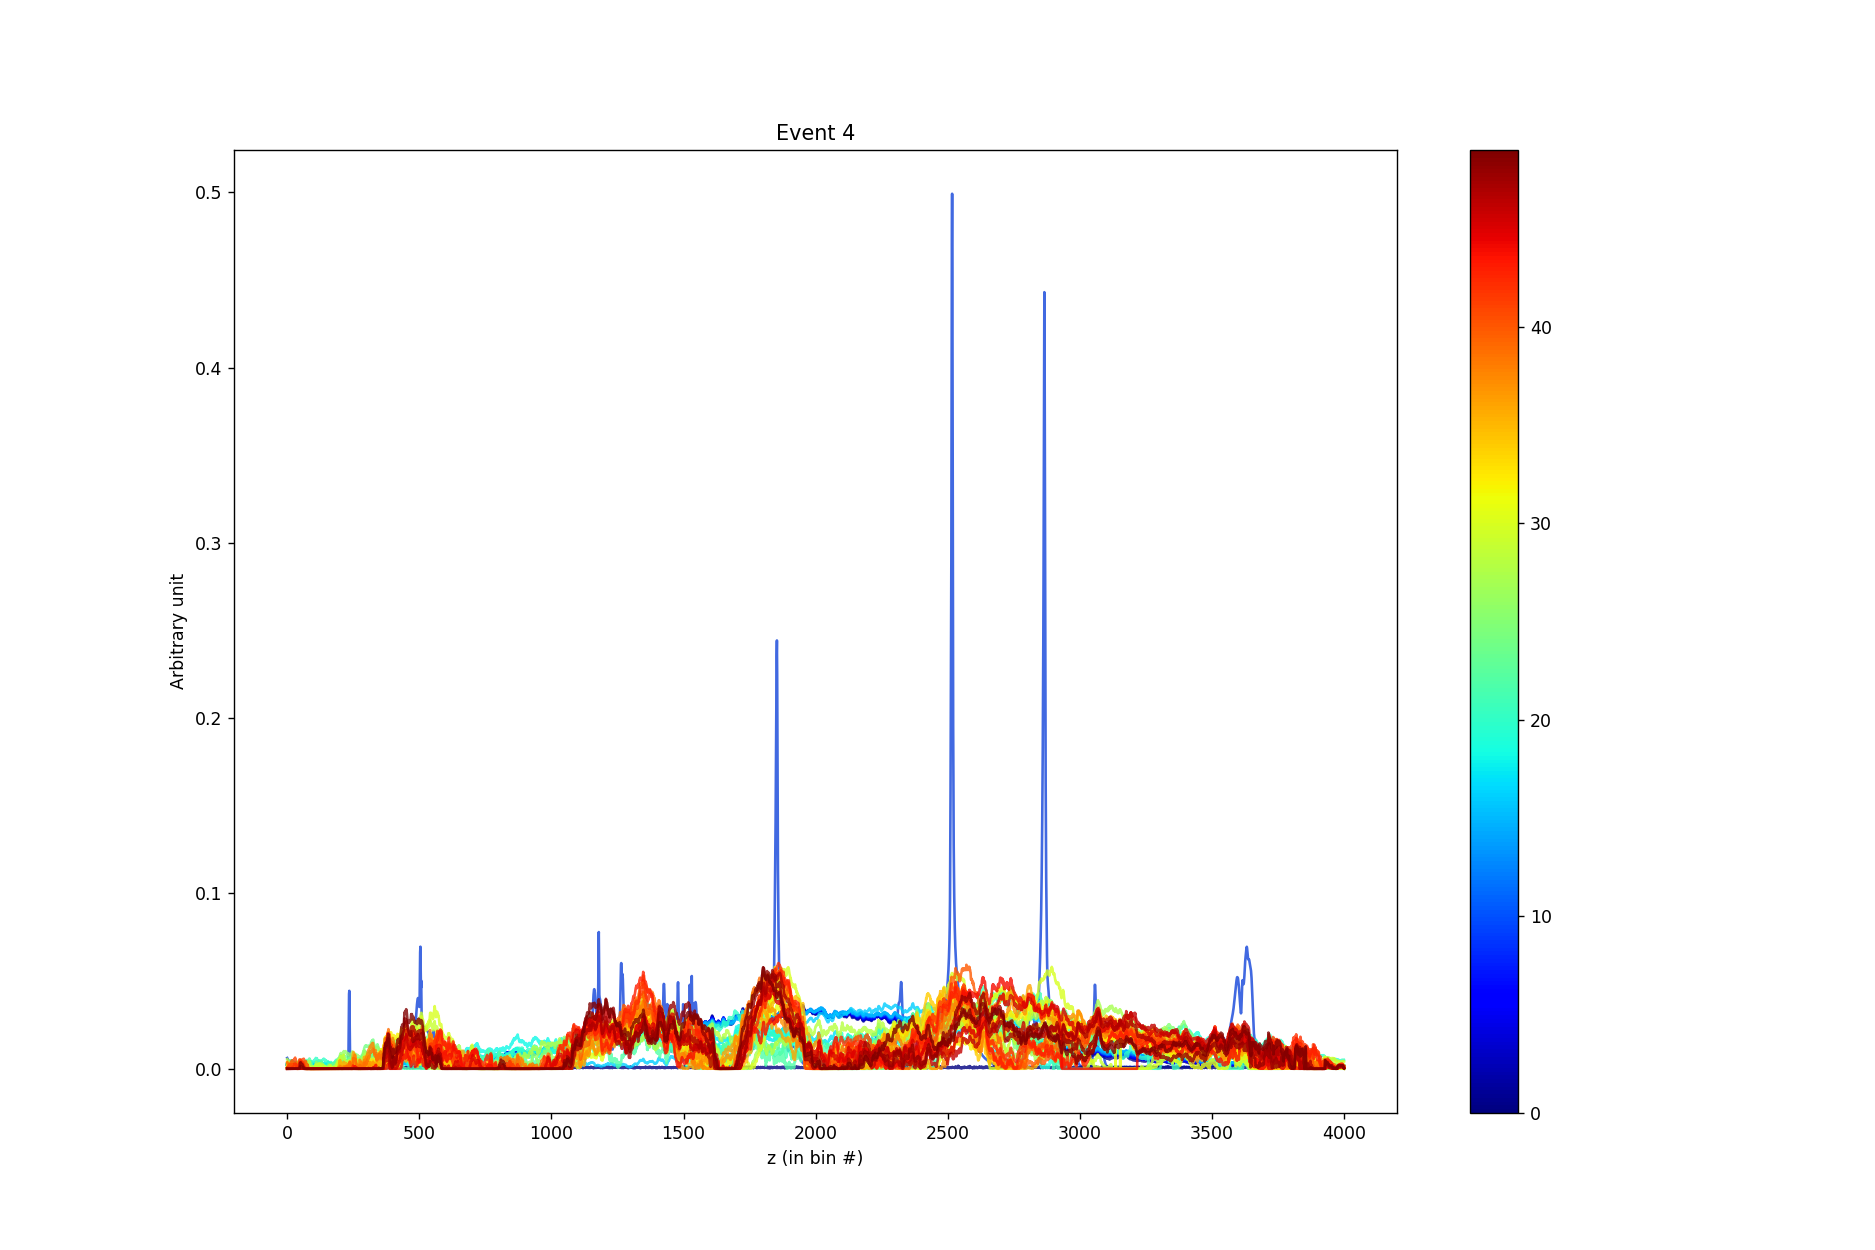

<IPython.core.display.Javascript object>


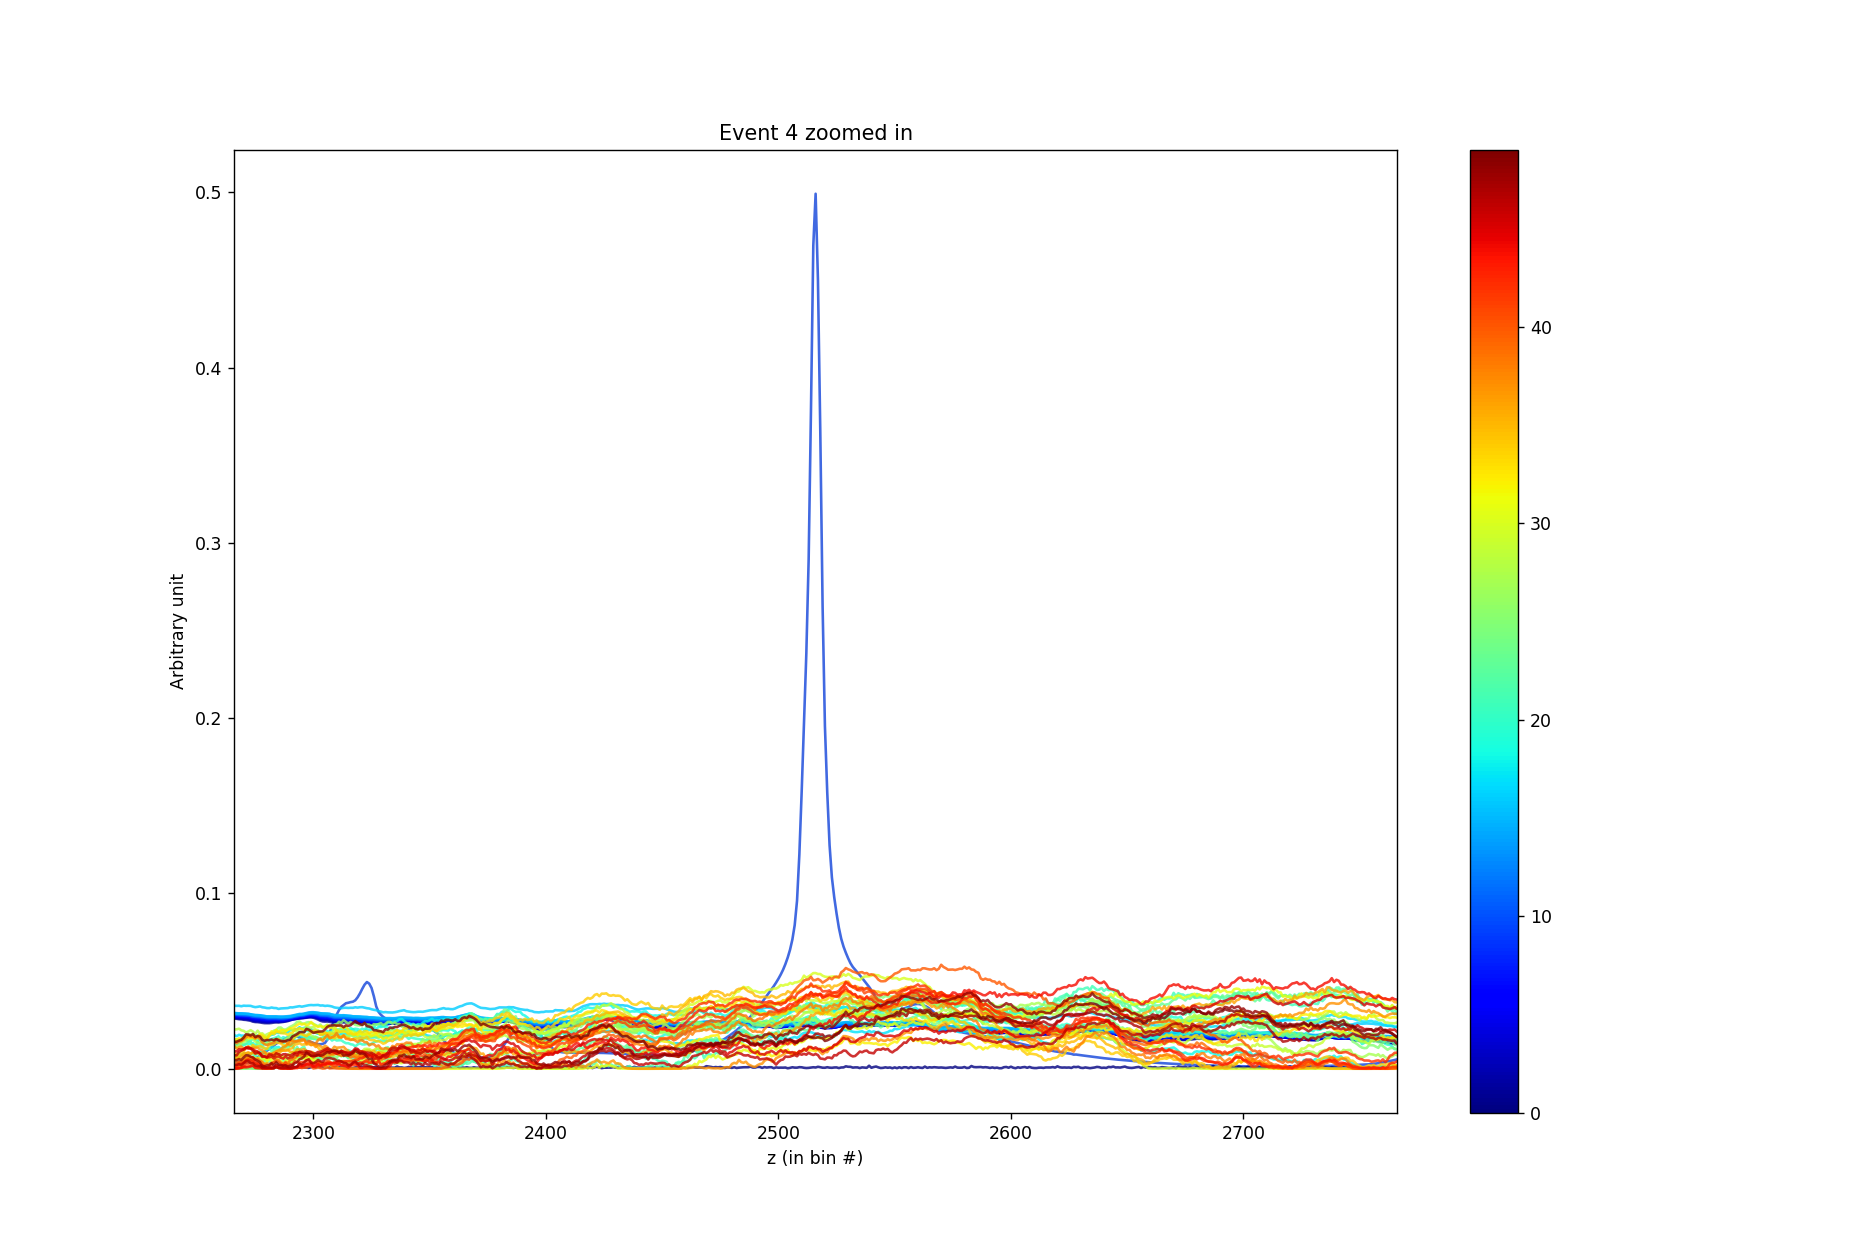

In [15]:
plot_DDplus_hists(state_dicts, data)